# Testing the surface area calculator on Tantangara Reservoir
This notebook is a proof of concept that converts depth to surface area for Tantangara reservoir. You can try running another reservoir if you like, just change the file name and you'll probably have to change the buffer too for the satellite query. This notebook does not use the bounding boxes so getting the satellite image right is a bit hard. This was the first notebook I made before I fixed up the queries and stuff.

## Import relevant python modules and data handling

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import rasterio
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

## Enter name of the depth gauge file

In [2]:
csv = '00_Library/Tantangara_410543.csv'
pd.read_csv(csv, skiprows=9)

,#Timestamp,Value,Interpolation Type,Quality Code
0,2000-01-01T00:00:00.000+10:00,1209.193,603,10
1,2000-01-02T00:00:00.000+10:00,1209.133,603,10
2,2000-01-03T00:00:00.000+10:00,1209.041,603,10
3,2000-01-04T00:00:00.000+10:00,1208.936,603,10
4,2000-01-05T00:00:00.000+10:00,1208.811,603,140
...,...,...,...,...
7510,2020-07-24T00:00:00.000+10:00,1210.417,603,10
7511,2020-07-25T00:00:00.000+10:00,1210.251,603,10
7512,2020-07-26T00:00:00.000+10:00,1210.100,603,10
7513,2020-07-27T00:00:00.000+10:00,1210.011,603,10


## Query the satellite data

In [3]:
#Get the name and ID of the gauge 
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID = gauge_number_df.at[0, 'gauge_ID']
ID_str = ID.astype(str)

gdf = gpd.read_file('00_Library_reservois/00_Library_reservois.shp')
gdf = gdf.set_index(['gauge_ID'])
name = gdf.at[ID_str, 'NAME']

#location for query (get lat and lon out of the depth gauge csv)
lat = gdf.at[ID_str, 'lat']
lon =  gdf.at[ID_str, 'lon']
buffer = 7000 #eventually I will use a bounding box to query the satellite data instead of lat, lon and buffer

## Organise data by depth (instead of time) and split into 1m intervals

there are this many 1 meter intervals for depth: 20


Text(0.5, 1.0, 'Depth duration curve: how much % of time the depth was at least this high.')

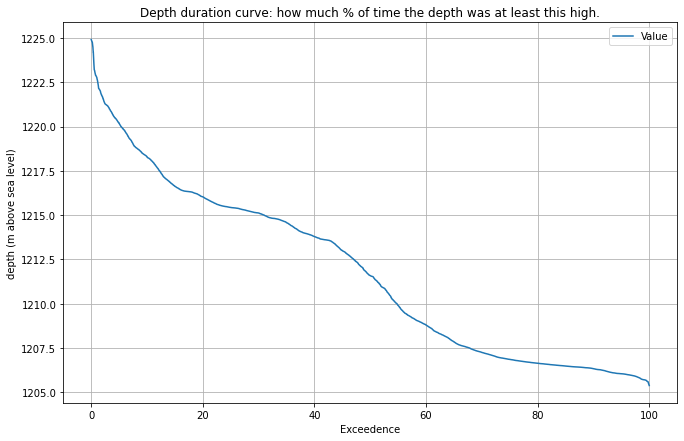

In [4]:
#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

print('there are this many 1 meter intervals for depth:', len(integer_list))
gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('depth (m above sea level)')
plt.grid(True)
plt.title('Depth duration curve: how much % of time the depth was at least this high.')

## Load satellite data parameters
This is how to query satellite data from the Geoscience Datacube. The dc.load() function loads the query, but we'll pass a Dask argument which will prevent it from loading actual images, we just want the parameters (this is way faster). At the moment I'm using lat and lon with a buffer to query the satellite data, but I want to change this to using a bounding box, which I made in ArcGIS. That would get the query more exact for every single reservoir. But I don't know how to write a query using a bounding box geoDataFrame, I'll figure it out later I guess

In [5]:
#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1980-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')

#use the Geoscience Datacube function .load() to load the satellite data
#use dask_chunks argument to load parameters only, not images (which would take hours!)
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

## Link satellite data with the stream gauge data
use Xarray to merge gauge data with satellite data on the time dimension

In [6]:
gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge

## Loop load satellite data for each 1m of depth
This one takes a while because of loading images, the cloudmask and the plotting. It would be nice if this could be faster. Technically the images don't need to be plotted, but I thought for the example notebook people would want to see the pictures.

This is the area as calculated from wet pixels at 1205 meters 2413125
This is the area as calculated from wet pixels at 1206 meters 2780000
This is the area as calculated from wet pixels at 1207 meters 3143125
This is the area as calculated from wet pixels at 1208 meters 3765000
This is the area as calculated from wet pixels at 1209 meters 4015000
This is the area as calculated from wet pixels at 1210 meters 4591250
This is the area as calculated from wet pixels at 1211 meters 4909375
This is the area as calculated from wet pixels at 1212 meters 5372500
This is the area as calculated from wet pixels at 1213 meters 5885625
This is the area as calculated from wet pixels at 1214 meters 6353125
This is the area as calculated from wet pixels at 1215 meters 6725000
This is the area as calculated from wet pixels at 1216 meters 7169375
This is the area as calculated from wet pixels at 1217 meters 7971875
This is the area as calculated from wet pixels at 1218 meters 8772500
This is the area as 

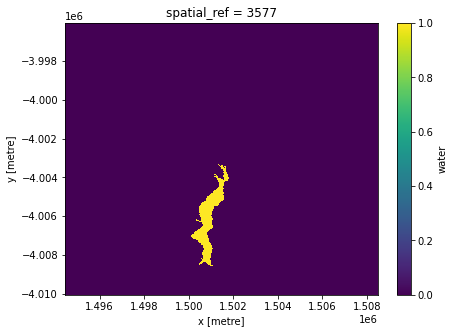

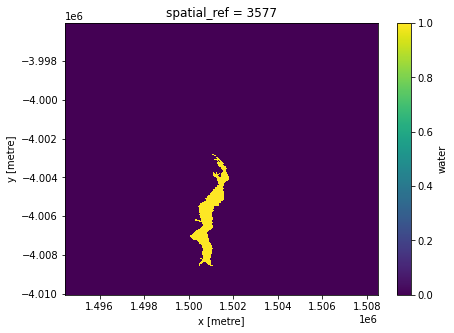

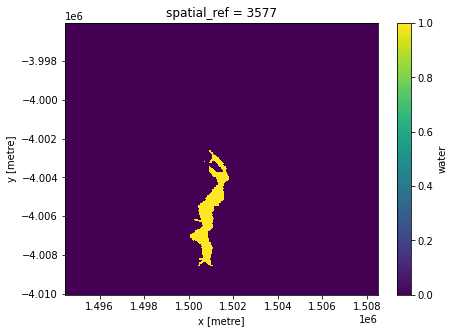

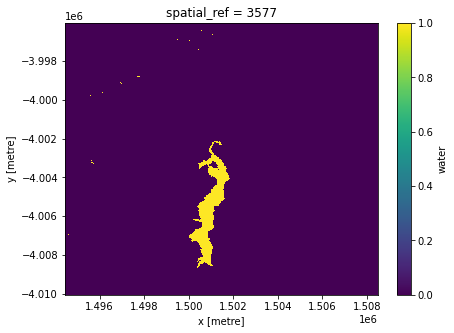

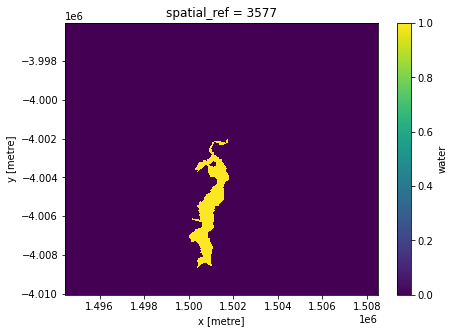

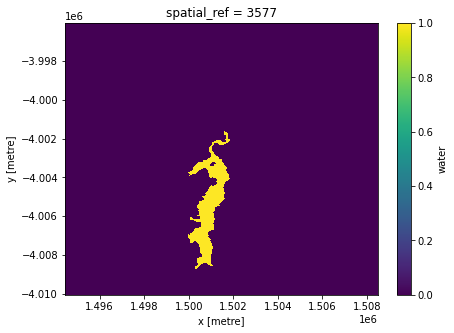

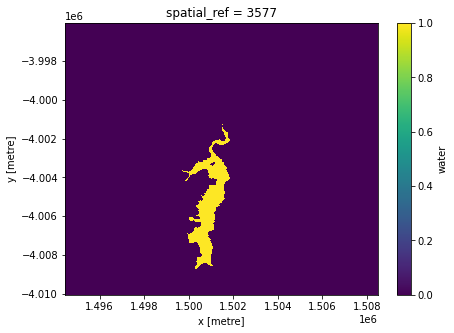

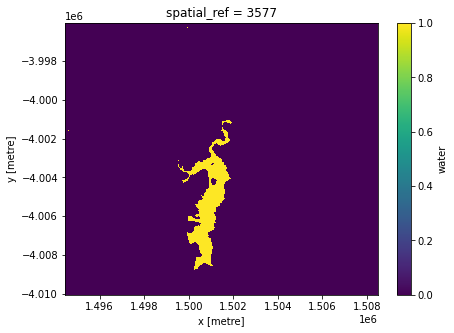

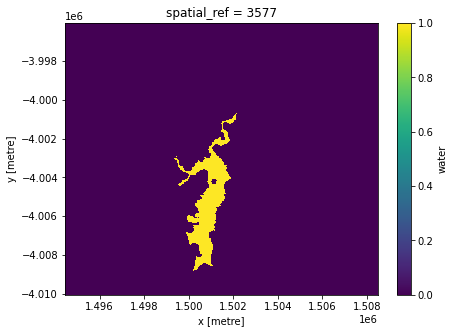

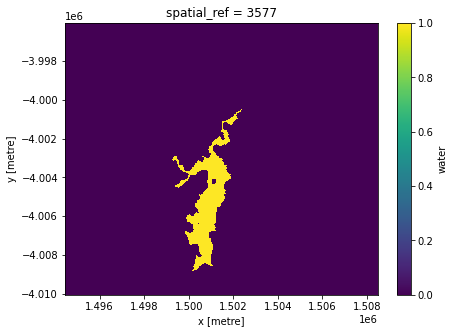

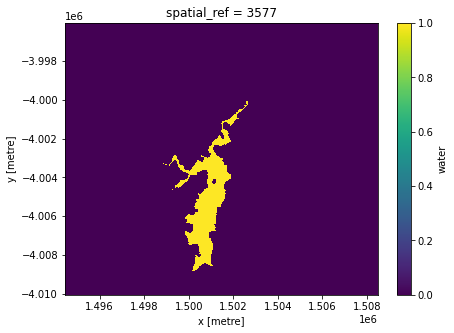

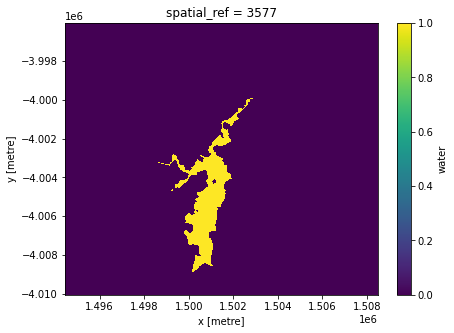

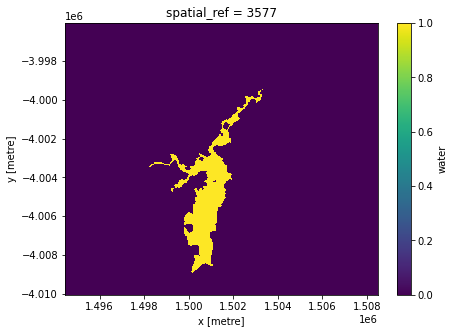

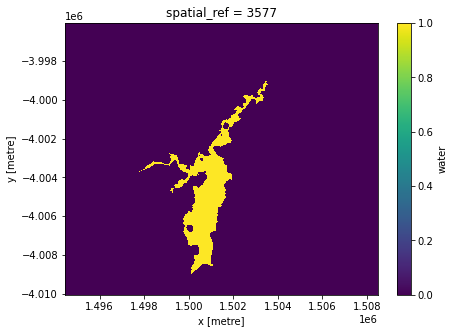

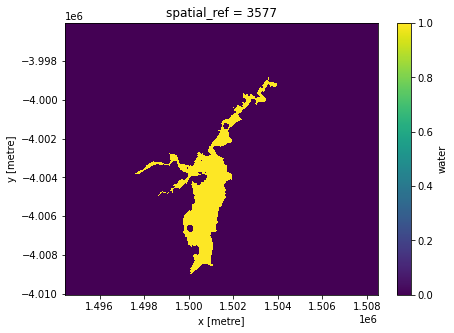

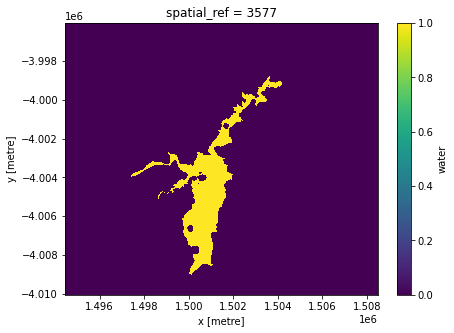

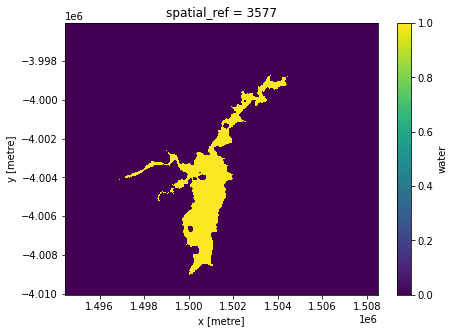

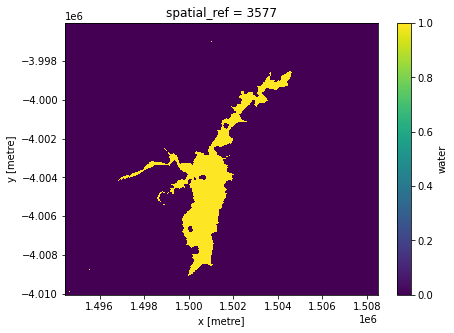

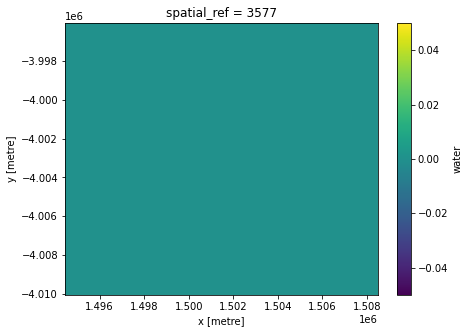

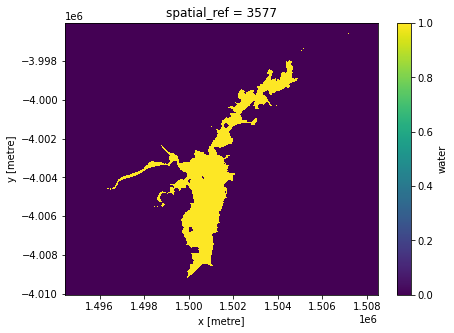

In [7]:
surface_area_list = []

for i in integer_list:
    specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    date_list = specified_level.time.values
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
   
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
    print('This is the area as calculated from wet pixels at', i, 'meters', area_m2)

    #Plotting the image
    frequency.plot(figsize = (7,5))

## Fix zero values
Eventually I will figure out a way to fix all zero or bad values for any reservoir but I'm just gonna hard code this in for now because I got other things I need to do

In [8]:
new_surface_area_list = [i if i > 0 else 12446875 for i in surface_area_list] 
new_surface_area_list

[2413125,
 2780000,
 3143125,
 3765000,
 4015000,
 4591250,
 4909375,
 5372500,
 5885625,
 6353125,
 6725000,
 7169375,
 7971875,
 8772500,
 9557500,
 10153750,
 10800625,
 11535625,
 12446875,
 13358125]

## Hydrograph to monthly surface area
The hydrograph is depth over time. Now we have surface area for depth, so we can get surface area over time

This is the original hydrograph: depth over time


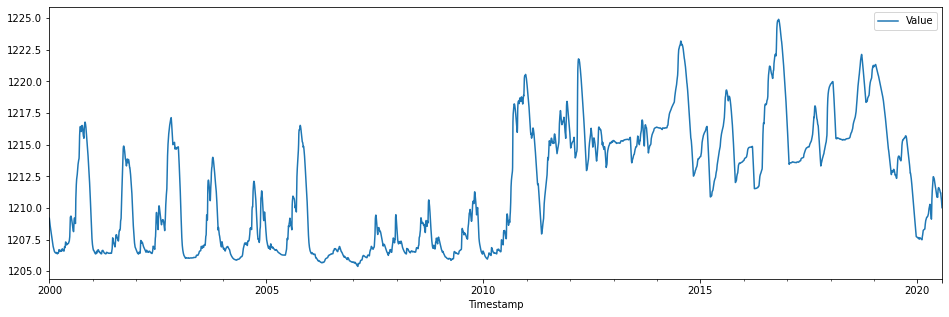

In [9]:
orig_hydrograph = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'), #Tells it to set Timestamp as the index column
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #turns timestamp into date
orig_hydrograph = orig_hydrograph.drop(columns=['Interpolation Type', 'Quality Code'])
orig_hydrograph.plot(figsize=(16, 5))
print('This is the original hydrograph: depth over time')

In [10]:
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list, columns=['Depth'])
depth_to_area_df['Surface Area'] = new_surface_area_list
depth_to_area_df['Name'] = name
depth_to_area_df['ID'] = ID_str
depth_to_area_df

,Depth,Surface Area,Name,ID
0,1205,2413125,TANTANGARA RESERVOIR,410543
1,1206,2780000,TANTANGARA RESERVOIR,410543
2,1207,3143125,TANTANGARA RESERVOIR,410543
3,1208,3765000,TANTANGARA RESERVOIR,410543
4,1209,4015000,TANTANGARA RESERVOIR,410543
5,1210,4591250,TANTANGARA RESERVOIR,410543
6,1211,4909375,TANTANGARA RESERVOIR,410543
7,1212,5372500,TANTANGARA RESERVOIR,410543
8,1213,5885625,TANTANGARA RESERVOIR,410543
9,1214,6353125,TANTANGARA RESERVOIR,410543


## Prepare for merge
First we gotta append the depth integers to the original hydrograph (as opposed to the depth values). This way we can match it up to the surface area using the table we created above (we will be merging the table with the hydrograph on the depth integer column)

In [11]:
orig_hydrograph = orig_hydrograph.dropna()

hydrograph1 = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#', parse_dates=['Timestamp'])
hydrograph1 = hydrograph1.drop(columns=['Interpolation Type', 'Quality Code'])
hydrograph1 = hydrograph1.dropna()

depth_integers = hydrograph1.Value.astype(np.int64)
depth_integers_list = depth_integers.to_list()

orig_hydrograph['Depth'] = depth_integers_list
orig_hydrograph['Date'] = orig_hydrograph.index
orig_hydrograph

,Value,Depth,Date
Timestamp,,,
2000-01-01,1209.193,1209,2000-01-01
2000-01-02,1209.133,1209,2000-01-02
2000-01-03,1209.041,1209,2000-01-03
2000-01-04,1208.936,1208,2000-01-04
2000-01-05,1208.811,1208,2000-01-05
...,...,...,...
2020-07-24,1210.417,1210,2020-07-24
2020-07-25,1210.251,1210,2020-07-25
2020-07-26,1210.100,1210,2020-07-26


## Convert depth to surface area and make a table
We can now add surface area to the original dataframe, drop the depth column and plot the surface area over time

This is a table and the graph of surface area over time (monthly). You can save this out as a csv file


,Surface Area,Name,ID
Date,,,
2000-01-01,108758750,TANTANGARA RESERVOIR,410543
2000-02-01,80983125,TANTANGARA RESERVOIR,410543
2000-03-01,86180000,TANTANGARA RESERVOIR,410543
2000-04-01,83400000,TANTANGARA RESERVOIR,410543
2000-05-01,92716250,TANTANGARA RESERVOIR,410543
...,...,...,...
2020-03-01,121715000,TANTANGARA RESERVOIR,410543
2020-04-01,126788750,TANTANGARA RESERVOIR,410543
2020-05-01,158678125,TANTANGARA RESERVOIR,410543


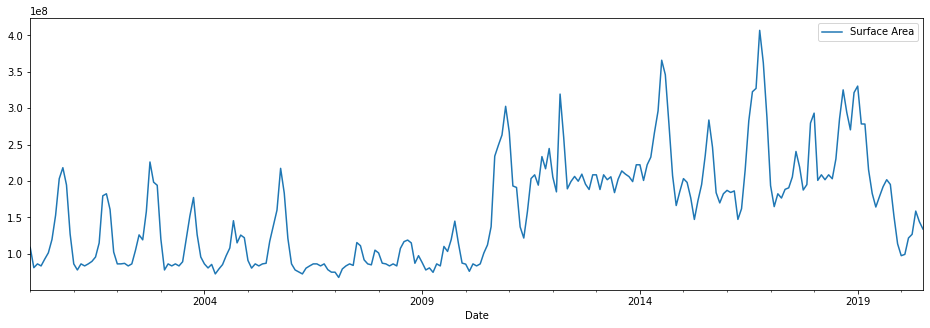

In [12]:
merged = (orig_hydrograph
          .merge(depth_to_area_df[['Surface Area', 'Depth', 'Name', 'ID']], on='Depth'))
df1 = merged.sort_values(['Date'])
#pd.read_csv('surface_area_timeseries.csv', parse_dates=['Date'])
df = df1.set_index(['Date'])
#Use this pandas function MS (monthly summary) to 
df = df.resample('MS').sum()
df = df.drop(columns = ['Value', 'Depth'])
df['Name'] = df1.at[0, 'Name']
df['ID'] = df1.at[0, 'ID']
df.plot(figsize=(16, 5))
print('This is a table and the graph of surface area over time (monthly). You can save this out as a csv file')
df

nice one